In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import matplotlib.pyplot as plt
from datetime import datetime 
import gc
import numpy as np

In [2]:
import torch
import tensorboard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Here we set up some parameters which will be used later in the code
# parameters
RANDOM_SEED = 12
# LEARNING_RATE = 0.001
# BATCH_SIZE = 32
# N_EPOCHS = 15

# IMG_SIZE = 32
# N_CLASSES = 10

In [5]:
# convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([transforms.ToTensor()])
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

# declaring the training and test datasets
train_data = datasets.CIFAR10('data', train=True,download=True,transform = train_transform)
test_data = datasets.CIFAR10('data', train=False,download=True,transform = test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
set1 = list(range(0,len(train_data),2))
set2 = list(range(1,len(train_data),2))
train_1 = torch.utils.data.Subset(train_data,set1)
train_2 = torch.utils.data.Subset(train_data,set2)

In [7]:
train_dataloader1 = torch.utils.data.DataLoader(train_1, batch_size=100, shuffle=True, num_workers=2)
train_dataloader2 = torch.utils.data.DataLoader(train_2, batch_size=100, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True, num_workers=2)

In [8]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=6,stride=1)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=84, out_features=42),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(in_features=42, out_features=n_classes),
            
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [9]:
def train(train_loader, model, criterion, optimizer, device):

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    Loss = running_loss / len(train_loader.dataset)
    return model, optimizer, Loss

In [10]:
def test(test_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    
    for X, y_true in test_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    Loss = running_loss / len(test_loader.dataset)
        
    return model, Loss

In [11]:
def plot_loss(train_losses, valid_losses):

    # change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Testing loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [12]:
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
#             print("Probabilities",y_prob)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

In [13]:
def evaluation(model, criterion, optimizer, train_loader, test_loader, epochs, device, print_every=1):
    
    # set objects for storing metrics
    train_losses = []
    test_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        writer.add_scalar("Loss train", train_loss, epoch+1)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, test_loss = test(test_loader, model, criterion, device)
            writer.add_scalar("Loss test", test_loss, epoch+1)
            test_losses.append(test_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            writer.add_scalar("Train Accuracy", train_acc, epoch+1)
            test_acc = get_accuracy(model, test_loader, device=device)
            writer.add_scalar("Test Accuracy", test_acc, epoch+1)    
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Test loss: {test_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Test accuracy: {100 * test_acc:.2f}')

            
    plot_loss(train_losses, test_losses)
#     train_arr = np.array(train_losses)
#     train_tensor = torch.as_tensor(train_arr)
#     test_arr = np.array(test_losses)
#     test_tensor = torch.as_tensor(test_arr)
#     writer.add_scalar("Loss train", train_losses, epochs)
#     writer.add_scalar("Loss test", test_losses, epochs)
    
    return model, optimizer, (train_losses,test_losses)

In [14]:

model = LeNet5(10).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

21:48:28 --- Epoch: 0	Train loss: 2.3045	Test loss: 2.3041	Train accuracy: 10.14	Test accuracy: 10.00
21:49:29 --- Epoch: 1	Train loss: 2.3043	Test loss: 2.3040	Train accuracy: 10.14	Test accuracy: 10.00
21:50:28 --- Epoch: 2	Train loss: 2.3041	Test loss: 2.3039	Train accuracy: 10.14	Test accuracy: 10.00
21:51:28 --- Epoch: 3	Train loss: 2.3041	Test loss: 2.3038	Train accuracy: 10.14	Test accuracy: 10.00
21:52:27 --- Epoch: 4	Train loss: 2.3039	Test loss: 2.3037	Train accuracy: 10.14	Test accuracy: 10.00
21:53:25 --- Epoch: 5	Train loss: 2.3038	Test loss: 2.3036	Train accuracy: 10.14	Test accuracy: 10.00
21:54:24 --- Epoch: 6	Train loss: 2.3039	Test loss: 2.3036	Train accuracy: 10.14	Test accuracy: 10.00
21:55:23 --- Epoch: 7	Train loss: 2.3038	Test loss: 2.3035	Train accuracy: 10.14	Test accuracy: 10.00
21:56:22 --- Epoch: 8	Train loss: 2.3037	Test loss: 2.3034	Train accuracy: 10.14	Test accuracy: 10.00
21:57:21 --- Epoch: 9	Train loss: 2.3035	Test loss: 2.3033	Train accuracy: 10.14	T

/var/folders/mv/39f6vvvn1kb8pjc2zbvyxr5w0000gn/T/ipykernel_4147/308483355.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


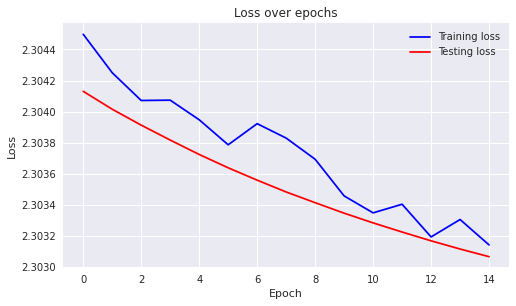

In [15]:
model, optimizer, _ = evaluation(model, criterion, optimizer, train_dataloader1, test_dataloader, 15, device)

In [17]:
%reload_ext tensorboard
%tensorboard --logdir './runs'

Reusing TensorBoard on port 6007 (pid 3694), started 0:22:28 ago. (Use '!kill 3694' to kill it.)